In [1]:
sys.argv = ['-f'] # override any sysargs given by ipy or jupyter and allow this to be run inside an ipynb

In [2]:
import scipy.io
import os
import numpy as np
from loader import load_all_mats
from logger import logger
logger.setLevel('INFO')

In [3]:
# Load all data:
data, dataset = load_all_mats()

2021-05-11 18:04:34 Connors-MacBook-Pro.local logger[50641] INFO Loading all data . . .
2021-05-11 18:05:02 Connors-MacBook-Pro.local logger[50641] NOTICE All data loaded.


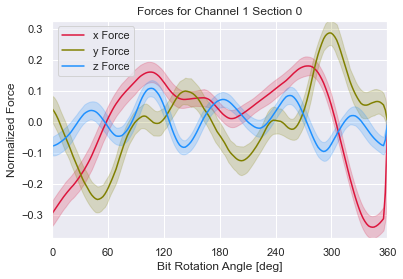

No handles with labels found to put in legend.


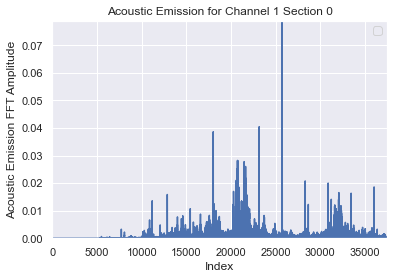

No handles with labels found to put in legend.


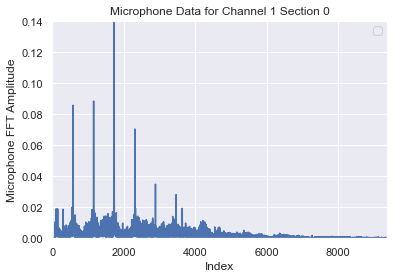

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

experiments = [*data.values()]
experiment = experiments[0]
channel = experiment.data[0]
section_num = 0
section = channel.sections[section_num]

plt.figure()
for force, color in [('x','crimson'), ('y', 'olive'), ('z', 'dodgerblue')]:
    mu_field, sig_field = f'F{force}_mu', f'F{force}_sig'
    y = getattr(section,mu_field).numpy()
    y_err = 2 * getattr(section,sig_field).numpy() # +- 2 sigma
    x = np.linspace(0, 360, y.size)
    plt.plot(x, y, '-', color=color, label=f'{force} Force')
    plt.fill_between(x, y - y_err, y + y_err, alpha=0.2, color=color)
plt.xticks(range(361)[::60])
plt.gca().margins(0)
plt.xlabel('Bit Rotation Angle [deg]')
plt.ylabel(f'Normalized Force')
plt.legend()
plt.title(f'Forces for Channel {channel.channel_num} Section {section_num}')
plt.show()

plt.figure()
y = section.AE_FFT_val
plt.plot(y)
plt.gca().margins(0)
plt.xlabel('Index')
plt.ylabel(f'Acoustic Emission FFT Amplitude')
plt.legend()
plt.title(f'Acoustic Emission for Channel {channel.channel_num} Section {section_num}')
plt.show()

plt.figure()
y = section.Mic_FFT_val
plt.plot(y)
plt.gca().margins(0)
plt.xlabel('Index')
plt.ylabel(f'Microphone FFT Amplitude')
plt.legend()
plt.title(f'Microphone Data for Channel {channel.channel_num} Section {section_num}')
plt.show()

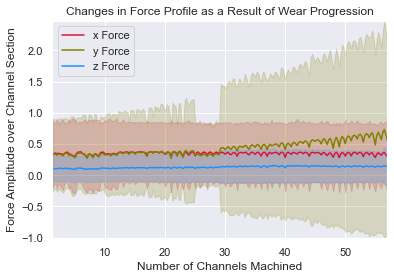

In [5]:
from scipy.interpolate import interp1d
# Plot force as wear progression:
experiments = [*data.values()]
num_experiments = len(experiments)


# Collect the amplitudes for every force vector for each axis in each channel section across all experiments:
# (Creates a list of matrices containing the number (or partial number, ex. 2.5) of channels machined vs the 
# force amplitude at that point for every experiment):
progression = dict(x=[], y=[], z=[])
max_channels_machined = (0, np.zeros(0))
for exp in experiments:
    num_sections = sum(len(channel.sections) for channel in exp.data)
    progression['x'].append(np.zeros((2,num_sections)))
    progression['y'].append(np.zeros((2,num_sections)))
    progression['z'].append(np.zeros((2,num_sections)))
    section_idx = 0
    for channel in exp.data:
        for i, section in enumerate(channel.sections):
            num_channels_machined = channel.channel_num + (i+1) / len(channel.sections)
            for force in ['x','y','z']:
                F = getattr(section,f'F{force}_mu').numpy()
                amplitude = (np.max(F) - np.min(F))/2
                progression[force][-1][:,section_idx] = np.asarray([num_channels_machined, amplitude])
            section_idx += 1

    # When all channel sections in the experiment are added,
    # check if this number vector is the longest. If so, cache it for later upsampling of other channels:
    if progression['x'][-1].shape[1] > max_channels_machined[0]:
        max_channels_machined = (progression['x'][-1].shape[1], progression['x'][-1][0,:])


progression_stacks = dict()
for force in ['x','y','z']:
    # Resample (upsample) all matrices to have the same number of points, the maximum, then stack all 
    # uniformly sized force amplitude vectors with each row coming from a different experiment:
    stack = []
    for i in range(len(progression[force])):
        exp = progression[force][i]
        stack.append(interp1d(exp[0,:], exp[1,:], kind='linear', fill_value='extrapolate')(max_channels_machined[1]))

    # vstack them all and get the mean and std across all experiments:
    progression_stack = np.vstack(stack)
    mean = np.mean(progression_stack, axis=0)
    std = np.std(progression_stack, axis=0)
    progression_stacks[force] = (mean, std)
    

# Display Results:
x = max_channels_machined[1]
plt.figure()
for force, color in [('x','crimson'), ('y', 'olive'), ('z', 'dodgerblue')]:
    y, std = progression_stacks[force]
    y_err = y + 2 * std # +- 2 sigma
    plt.plot(x, y, color=color, label=f'{force} Force')
    plt.fill_between(x, y - y_err, y + y_err, alpha=0.2, color=color)
plt.gca().margins(0)
plt.xlabel('Number of Channels Machined')
plt.ylabel(f'Force Amplitude over Channel Section')
plt.legend(loc='upper left')
plt.title(f'Changes in Force Profile as a Result of Wear Progression')
plt.show()

Text(0.5, 1.0, 'Microphone 1-Sided Amp. Spectrum for 60k-15mm-100um, Channel 0, Section 0')

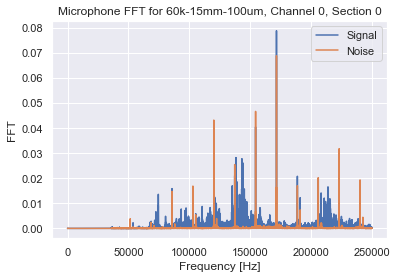

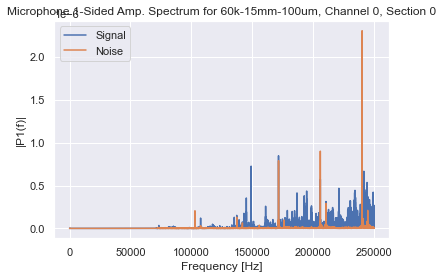

In [6]:
exp = [*data.values()][0]
section = exp.data[0].sections[0]

# Display FFT Results:
sig_fft = section.AE_FFT.numpy()
bg_fft = section.AE_FFT_BG.numpy()

plt.figure()
plt.plot(sig_fft[1,:],sig_fft[0,:])
plt.plot(bg_fft[1,:],bg_fft[0,:])
plt.xlabel('Frequency [Hz]')
plt.ylabel('FFT')
plt.legend(('Signal','Noise'))
plt.title(f'Microphone FFT for {exp.dir_name}, Channel 0, Section 0')

# One-Sided Amp. Spectrum:
L = sig_fft[0,:].size//2*2
P2 = np.abs(sig_fft[0,:]/L)
P1 = P2[0:int(L/2)]
P1[1:-2] = 2*P1[1:-2]
P1_f = sig_fft[1,0:-1:2]

L_bg = bg_fft[0,:].size//2*2
P2_bg = np.abs(bg_fft[0,:]/L_bg)
P1_bg = P2_bg[0:int(L_bg/2)]
P1_bg[1:-2] = 2*P1_bg[1:-2]
P1_bg_f = bg_fft[1,0:-1:2]

plt.figure()
plt.plot(P1_f,P1)
plt.plot(P1_bg_f,P1_bg)
plt.xlabel('Frequency [Hz]')
plt.ylabel('|P1(f)|')
plt.legend(('Signal','Noise'))
plt.title(f'Microphone 1-Sided Amp. Spectrum for {exp.dir_name}, Channel 0, Section 0')

# Power Spectral Density:
# must subtract PSD not FFT (just like how you can add var, not sigma)



In [7]:
# Plot Section-wise Spectrogram for an experiment:
import matplotlib.pyplot as plt
import numpy as np

exp = [*data.values()][0]
# Grab FFT data for all channels:
ns = np.cumsum([1 for d in exp.data for s in d.sections])
print(ns)

sig_ffts = [s.AE_FFT.numpy() for d in exp.data for s in d.sections]


bg_ffts = [s.AE_FFT_BG.numpy() for d in exp.data for s in d.sections]



[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224]


In [ ]:
from scipy import signal
from scipy.fft import fftshift
import matplotlib.pyplot as plt

fs = 10e3
N = 1e5
amp = 2 * np.sqrt(2)
noise_power = 0.01 * fs / 2
time = np.arange(N) / float(fs)
mod = 500*np.cos(2*np.pi*0.25*time)
carrier = amp * np.sin(2*np.pi*3e3*time + mod)
noise = np.random.normal(scale=np.sqrt(noise_power), size=time.shape)
noise *= np.exp(-time/5)
x = carrier + noise

f, t, Sxx = signal.spectrogram(x, fs)
plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()